In [1]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 8, 16
from matplotlib.pyplot import imshow
import rawpy
import numpy as np
import cv2
import os

In [2]:
def getRaw(path):
    """
    读取raw文件,我是索尼的ARW，其他的raw文件需要测试
    :param path: 图片路径
    :return:rgb图像
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"文件未找到: {path}")
    with rawpy.imread(path) as raw:
        rgb_image = raw.postprocess(output_color=rawpy.ColorSpace.sRGB)
    return rgb_image


def cvtRGB2BGR(rgb_image):
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)


def cvtRGB2HSV(rgb_image):
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)


def cvtBGR2RGB(bgr_image):
    return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)


def cvtBGR2HSV(bgr_image):
    return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)


def cvtHSV2RGB(hsv_image):
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)


def cvtHSV2BGR(hsv_image):
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)


def cvtBGR2GRAY(bgr_image):
    return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)


def crop_img_xy(bgr_image):
    """
    通过颜色检测裁剪图片, 返回裁剪区域的坐标
    这个函数是用来把翻拍胶卷的外面一圈黑边自动裁切掉的，扫描的图片需要另外实现如何分割图像
    :param bgr_image: opencv处理的bgr图像
    :return: {x, y, w, h}坐标字典
    """
    hsv_image = cvtBGR2HSV(bgr_image)
    lower_black = np.array([0, 0, 0])  # 低阈值 (接近完全黑)
    upper_black = np.array([180, 255, 50])  # 高阈值 (稍微允许一些暗色)
    mask = cv2.inRange(hsv_image, lower_black, upper_black)
    non_black_mask = cv2.bitwise_not(mask)  # 非黑色部分
    contours, _ = cv2.findContours(non_black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return{
            'x': x,
            'y': y,
            'w': w,
            'h': h
        }
    else: return None
    
    
def shrink(ix, iy, iw, ih, size=0.9):
    """
    缩小裁剪区域，这里是为了避免黑边和齿孔带来的极黑/极白的影响，缩小裁剪区域
    输入的是crop_img_xy的返回值坐标，在这个坐标基础上缩小裁剪区域
    :param ix: 坐标x
    :param iy: 坐标y
    :param iw: 宽度
    :param ih: 高度
    :param size: 缩小的比例
    :return: 新坐标字典
    """
    shrink_factor = size
    new_w = int(iw * shrink_factor)
    new_h = int(ih * shrink_factor)
    new_x = ix + int(abs(iw - new_w) / 2)
    new_y = iy + int(abs(ih - new_h) / 2)
    # print(ix, iy, iw, ih)
    # print(new_x, new_y, new_w, new_h)
    return {'x': new_x,
            'y': new_y,
            'w': new_w,
            'h': new_h}


def apply_white_balance(image_rgb):
    """
    自动白平衡：根据图像的RGB通道的平均值调整红色、绿色和蓝色通道的增益，使其更自然。
    :param image_rgb: RGB图像
    :return: 调整后的RGB图像
    """
    avg_r = np.mean(image_rgb[:, :, 0])  # 红色通道平均值
    avg_g = np.mean(image_rgb[:, :, 1])  # 绿色通道平均值
    avg_b = np.mean(image_rgb[:, :, 2])  # 蓝色通道平均值
    
    # 计算所有通道的整体平均值
    avg_all = (avg_r + avg_g + avg_b) / 3.0

    # 计算每个通道的增益系数
    gain_r = avg_all / avg_r
    gain_g = avg_all / avg_g
    gain_b = avg_all / avg_b

    # 调整RGB通道
    image_rgb[:, :, 0] = np.clip(image_rgb[:, :, 0] * gain_r, 0, 255)  # Red通道
    image_rgb[:, :, 1] = np.clip(image_rgb[:, :, 1] * gain_g, 0, 255)  # Green通道
    image_rgb[:, :, 2] = np.clip(image_rgb[:, :, 2] * gain_b, 0, 255)  # Blue通道
    
    return image_rgb

def auto_color_balance(img):
    """
    归一化自动颜色平衡
    :param img: 
    :return: 
    """
    channels = cv2.split(img)
    out_channels = []
    for channel in channels:
        norm_channel = cv2.normalize(channel, None, 0, 255, cv2.NORM_MINMAX)
        out_channels.append(norm_channel)
    return cv2.merge(out_channels)

def save_img(img, path,type='tif',quality=100):
    """
    保存图片
    :param img: opencv处理的图片
    :param path: 保存路径
    :param type: 保存类型
    :return: 是否保存成功
    """
    if type == 'tif':
        path+='.tif'
        cv2.imwrite(path, img)
        return True
    elif type == 'png':
        path+='.png'
        cv2.imwrite(path, img, [cv2.IMWRITE_PNG_COMPRESSION, quality])
        return True
    else:
        path+='.jpg'
        cv2.imwrite(path, img, [cv2.IMWRITE_JPEG_QUALITY, quality])
        return True
        
        
        

In [3]:
def process_img(input):
    try:
        rgb_image = getRaw(input)
        bgr_image = cvtRGB2BGR(rgb_image) # opencv
        crop_dict = crop_img_xy(bgr_image) # 裁切
        new_crop_dict = shrink(crop_dict['x'], crop_dict['y'], crop_dict['w'], crop_dict['h'],0.8) # 系数看有无齿孔动态调整
        process_tmp_img= bgr_image[new_crop_dict['y']:new_crop_dict['y']+new_crop_dict['h'], new_crop_dict['x']:new_crop_dict['x']+new_crop_dict['w']]
        img_inverted = cv2.bitwise_not(process_tmp_img)
        img_color_corrected = auto_color_balance(img_inverted)
        res_img=apply_white_balance(cvtBGR2RGB(img_color_corrected))
        imshow(res_img)
        return res_img
    except Exception as e:
        print("Error: ", e)
        return False

reading raw image... /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/in/_DSC4293.ARW


array([[[120, 158, 194],
        [122, 158, 180],
        [122, 161, 180],
        ...,
        [140, 158, 189],
        [133, 155, 185],
        [140, 152, 189]],

       [[120, 161, 198],
        [120, 158, 185],
        [122, 161, 180],
        ...,
        [138, 158, 185],
        [140, 158, 189],
        [143, 158, 189]],

       [[118, 161, 198],
        [118, 158, 180],
        [120, 161, 189],
        ...,
        [138, 161, 189],
        [146, 158, 189],
        [146, 158, 185]],

       ...,

       [[118, 147, 156],
        [111, 143, 156],
        [109, 143, 151],
        ...,
        [146, 152, 174],
        [148, 152, 185],
        [146, 152, 185]],

       [[118, 143, 146],
        [114, 143, 151],
        [111, 140, 146],
        ...,
        [143, 155, 189],
        [143, 155, 189],
        [143, 152, 180]],

       [[118, 143, 151],
        [116, 143, 146],
        [114, 140, 151],
        ...,
        [143, 155, 189],
        [140, 155, 185],
        [143, 155, 180]]

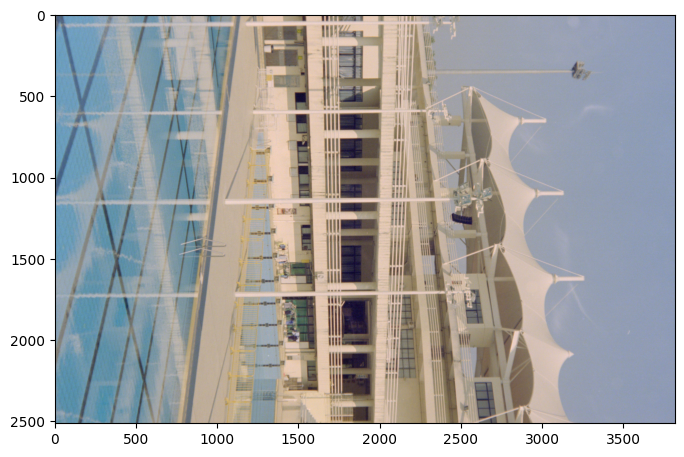

In [4]:
file_name = '_DSC4293.ARW'
out_file_name = file_name.split('.')[0]
root='/Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs'
input = f'{root}/in/{file_name}'
output = f'{root}/out/{out_file_name}'


process_img(input)

reading raw image... /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/in/_DSC4295.ARW
Saved: /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/out/2025-02-01/_DSC4295
reading raw image... /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/in/_DSC4294.ARW
Saved: /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/out/2025-02-01/_DSC4294
reading raw image... /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/in/_DSC4296.ARW
Saved: /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/out/2025-02-01/_DSC4296
reading raw image... /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/in/_DSC4297.ARW
Saved: /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/out/2025-02-01/_DSC4297
reading raw image... /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/in/_DSC4293.ARW
Saved: /Users/bumony/DevSpace/Softwares/Film_Decolorizer/imgs/out/2025-02-01/_DSC4293


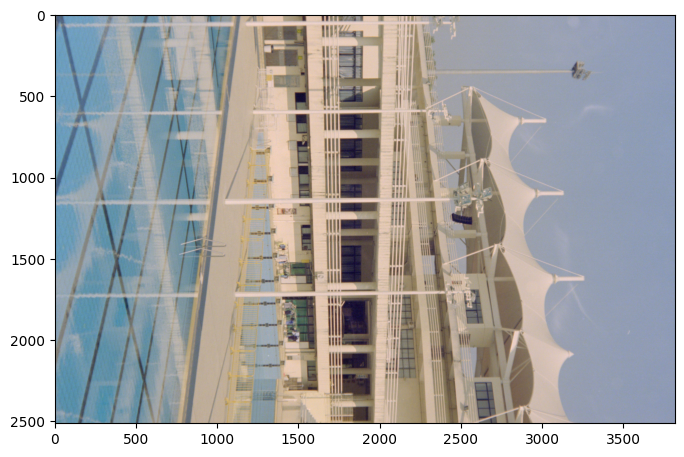

In [5]:
from os.path import exists
from os import mkdir
from datetime import datetime
today=datetime.now().strftime('%Y-%m-%d')
# 遍历input的文件夹，处理所有的raw文件
for root, dirs, files in os.walk(f'{root}/in'):
    for file in files:
        if file.endswith('.ARW'):
            input = f'{root}/{file}'
            out_file_name = file.split('.')[0]
            output_dir = f'{root.replace("in","out")}/{today}'
            output = f'{output_dir}/{out_file_name}'
            if not exists(output_dir):
                mkdir(output_dir)
            res_img=cvtBGR2RGB(process_img(input))
            save_img(res_img, output)
            print(f"Saved: {output}")